In [68]:
import scipy.io
import math
import numpy as np
import pickle
import tensorflow as tf

# dataset = scipy.io.loadmat('./Data/Wave.mat')
dataset = scipy.io.loadmat('./Data/Conductivity.mat')

# functions

def most_frequent(List):
	return max(set(List), key = List.count)

def random_feature_map(params):
  random_seed = 5
  tf.random.set_seed(random_seed)
  n_ker, sigma_list = params.get('n_ker'), params.get('sigma_list')
  L, N = params.get('L'), params.get('N')
  D = [None for i in range(n_ker)]
  for i in range(n_ker):
    D[i] = sigma_list[i] * np.random.randn(L, N)
  C = math.ceil(L/N)-1
  resd = L-C*N
  for i in range(n_ker):
    if(C*N == 0):
      D_temp = [None]
    else:
      D_temp = [None for i in range(C*N)]
    for c in range(C+1):
      G = np.random.randn(N, N)
      Q, R = np.linalg.qr(G)
      if(c < C):
        D_temp[c*N:c*N+N] = sigma_list[i]*Q
      else:
        D_temp[c*N:c*N+resd] = sigma_list[i]*Q[0:resd, :]
    v1 = np.random.chisquare(1, L)
    D[i] = np.dot(np.diag(np.sqrt(v1)),D_temp)
  return D

def MKOFL_Function_sing(y, x, params, theta, kernel_loss, D, global_weight):
  # PARAMETERS 
  n_ker, sigma_list = params.get('n_ker'), params.get('sigma_list')
  lamda, eta_l, eta_g, L = params.get('lamda'), params.get('eta_l'), params.get('eta_g'), params.get('L')

  fx, er_temp = [0 for i in range(n_ker)], [1 for i in range(n_ker)]


  for i in range(n_ker):

    theta0 = theta[i]
    sin0, cos0 = (np.sin(np.dot(D[i], x)) / math.sqrt(L)).tolist(), (np.cos(np.dot(D[i], x)) / math.sqrt(L)).tolist()
    kx0 = sin0 + cos0
    fx[i] = np.dot(kx0, theta0)
    er_temp[i] = math.pow((y - fx[i]), 2)
    grad = -2 * (y - fx[i]) * np.array(kx0)

    theta_temp = theta0 - (eta_l)*grad

    theta0 = theta_temp
    theta[i] = theta0.tolist()
  
  # PROBABILITY DISTRIBUTION (WEIGHTS)
  prob = (np.array(kernel_loss) / sum(kernel_loss)).tolist()

  # CHOOSE ONE INDEX ACCORDING TO THE ABOVE PROBABILIT
  temp_a = np.random.randn(1)[0]
  chosen_index = 0
  for tt in range(n_ker):
    if sum(prob[0:tt+1]) > temp_a:
      chosen_index = tt
      break
  
  f_hat_select = fx[chosen_index]

  for i in range(len(er_temp)):
    er_temp[i] = math.exp(-eta_g * er_temp[i])

  kernel_loss = (np.array(kernel_loss) * np.array(er_temp)).tolist()

  if max(kernel_loss) > 1e12:
    kernel_loss = (np.array(kernel_loss) / sum(kernel_loss)).tolist()

  er_sel = math.pow((y - f_hat_select), 2)

  return theta, er_sel, kernel_loss, chosen_index
  
Nuser = 100
X = dataset['X']
y = dataset['y']
X = X.tolist()
y = np.array(y).reshape(len(y)).tolist()
T = len(y)
N = len(X)
X_t = [list(i) for i in zip(*X)]
n_ker = 1
kernel_temp = [None for i in range(n_ker)]
for i in range(n_ker):
  kernel_temp[i] = math.pow(10, (i-5)/2)
kernel_temp[0] = 100

# Initializing parameters

L = 50
n_ker = len(kernel_temp)

params = {'N': N, 
          'ker_list': {'rbf'}, 
          'lamda' : 0.01,
          'sigma_list' : kernel_temp,
          'L' : L,
          'eta_l' : 0.5,
          'eta_g' : 0.5,
          'n_ker' : n_ker}

D = [None for i in range(n_ker)]
T = math.floor(T/Nuser)

D = random_feature_map(params)

# Initializing theta and local loss
kernel_loss_int, theta_int = [ [1 / n_ker for i in range(n_ker)] for j in range(Nuser)], [ [ [0 for i in range(2*L)] for j in range(n_ker)] for k in range(Nuser)]

global_prob = [1 / n_ker for i in range(n_ker)]

frequent_index, frequent_index_temp = 0, 0

theta, error_sel, ofl_sel, kernel_loss, select_index = theta_int, [ [1 for i in range(T)] for j in range(Nuser) ], [ [1 for i in range(T)] for j in range(Nuser) ], kernel_loss_int, [0 for i in range(Nuser)]

for t in range(T):
  if t == 0:
    frequent_index = np.random.randint(0, n_ker)
  else:
    frequent_index = frequent_index_temp
  
  temp_theta = [ [ [0 for i in range(2*L)] for j in range(n_ker)] for k in range(Nuser)]

  for u in range(Nuser):
    theta[u], error_sel[u][t], kernel_loss[u], select_index[u] = MKOFL_Function_sing(y[(t)*Nuser+u], X_t[(t)*Nuser+u], params, theta_int[u], kernel_loss_int[u], D, global_prob)
    
    if t==0:
      error_sel[u][t] = 1 # Initial MSE values
    ofl_sel[u][t] = np.mean(error_sel[u][0:t+1])
      # print(ofl_sel[u][t])
    kernel_loss_int[u] = kernel_loss[u]
    theta_int[u] = theta[u]

  # GENERATING A GLOBAL PROBABILITY DISTRIBUTION
  global_kernel_loss = [1 for i in range(n_ker)]

  for i in range(Nuser):
    global_kernel_loss = np.array(global_kernel_loss) * np.array(kernel_loss[u]).tolist()
  
  global_prob = (np.array(global_kernel_loss) / sum(global_kernel_loss)).tolist()

  frequent_index_temp = most_frequent(select_index)

  # GLOBAL MODEL UPDATE
  selected_theta = theta
  nn = len(theta)
  for kk in range(nn):
    temp_theta = (temp_theta + (1/nn)*np.array(selected_theta[kk])).tolist()
  
  # Global model-update from the aggregated theta's
  for u in range(Nuser):
    theta_int[u] = temp_theta[u]
# end of T

ofl_sel_mse = [0 for i in range(len(ofl_sel[0]))]

for u in range(Nuser):
  ofl_sel_mse = (np.array(ofl_sel_mse) + np.array(ofl_sel[u])).tolist()
  # print(ofl_sel_mse)
ofl_sel_mse = (np.array(ofl_sel_mse) / Nuser).tolist()

# with open("./Regression_mse/Wave_KL_n=1.pkl","wb") as f:
#     pickle.dump(ofl_sel_mse, f)
# with open("./Regression_mse/Conductivity_KL.pkl","wb") as f:
#     pickle.dump(ofl_sel_mse, f)

In [69]:
ofl_sel_mse

[1.0,
 0.616618125378392,
 0.46210741857868504,
 0.37214275309211076,
 0.3136803049489922,
 0.2729534728601158,
 0.24432278392472484,
 0.221315411043428,
 0.19929226843510744,
 0.18633815494662914,
 0.17448841834436885,
 0.16421452881379778,
 0.15545926933534354,
 0.14708153498036897,
 0.13931038647100966,
 0.13334053370347498,
 0.1287789637043186,
 0.12459573812435203,
 0.12064182438386911,
 0.11687419288830667,
 0.11437253108511218,
 0.11065848321361228,
 0.10757024792660634,
 0.1046664703076419,
 0.1016908952577408,
 0.0989642012407379,
 0.09669330089098926,
 0.09459046447145195,
 0.0926584807133874,
 0.09116567006945006,
 0.08988123379032661,
 0.08822212205794334,
 0.08710968271787832,
 0.08564911996689645,
 0.0845316172762862,
 0.08374548927159794,
 0.08431094233369536,
 0.08386406592193021,
 0.08295643035719234,
 0.08207817511174234,
 0.0811475916267561,
 0.08015622854581689,
 0.07896472559612572,
 0.07767725592591247,
 0.07700729117829314,
 0.07651067397428825,
 0.07571561861915

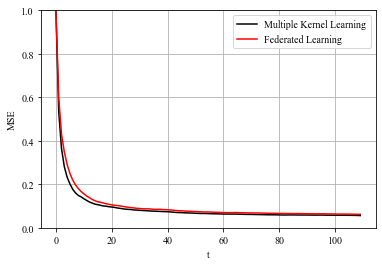

In [59]:
import pickle
import matplotlib.pyplot as plt

with open("./Regression_mse/Conductivity_KL.pkl","rb") as f:
    ofl_sel_mse = pickle.load(f)

with open("./Regression_mse/OFedAvg_Conductivity.pkl","rb") as f:
    ofl_sel_mse2 = pickle.load(f)

    
t1 = list(range(len(ofl_sel_mse)))
t2 = list(range(len(ofl_sel_mse)))
y1 = ofl_sel_mse
y2 = ofl_sel_mse2[0:len(ofl_sel_mse)]
# plotting the points
plt.plot(t1, y1, 'black', label='Multiple Kernel Learning')
plt.plot(t2, y2, 'red', label='Federated Learning')

plt.ylim([0, 1]) 
plt.legend(ncol = 1)

# naming the x axis
plt.xlabel('t')
# naming the y axis
plt.ylabel('MSE')
plt.rcParams["font.family"] = "Times New Roman"
# giving a title to my graph
 
# function to show the plot
plt.grid()
plt.savefig('./Figures/Regression_Conductivity.png', dpi=200, facecolor="white")
plt.show()



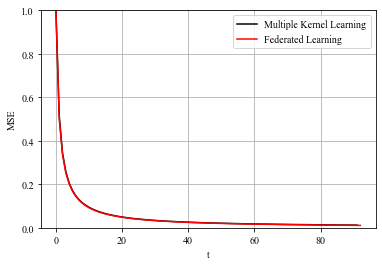

In [99]:
import pickle
import matplotlib.pyplot as plt

with open("./Regression_mse/Wave_KL_n=1.pkl","rb") as f:
    ofl_sel_mse = pickle.load(f)

with open("./Regression_mse/OFedAvg_Wave.pkl","rb") as f:
    ofl_sel_mse2 = pickle.load(f)

    
t1 = list(range(len(ofl_sel_mse)))
t2 = list(range(len(ofl_sel_mse2)))
y1 = ofl_sel_mse
y2 = ofl_sel_mse2
# plotting the points
plt.plot(t1, y1, 'black', label='Multiple Kernel Learning')
plt.plot(t2, y2, 'red', label='Federated Learning')

plt.ylim([0, 1]) 
plt.legend(ncol = 1)

# naming the x axis
plt.xlabel('t')
# naming the y axis
plt.ylabel('MSE')
plt.rcParams["font.family"] = "Times New Roman"
# giving a title to my graph
 
# function to show the plot
plt.grid()
plt.savefig('./Figures/Regression_Wave.png', dpi=200, facecolor="white")
plt.show()



In [103]:
with open("./Regression_mse/OFedAvg_Conductivity.pkl","rb") as f:
    ofl_sel_mse2 = pickle.load(f)

with open("./Regression_mse/Conductivity_KL.pkl","rb") as f:
    ofl_sel_mse = pickle.load(f)

In [104]:
ofl_sel_mse2

[1,
 0.6014029507001396,
 0.49999198772808695,
 0.4404689784896618,
 0.4016950265307679,
 0.37383846737628723,
 0.34945042540211174,
 0.33228417337515564,
 0.32048079465449214,
 0.29800825283112486,
 0.29434500377115247,
 0.28705321345274565,
 0.27924123859907213,
 0.2728378968156487,
 0.2667447061728357,
 0.26095554951753913,
 0.25118055581908694,
 0.24433537263865432,
 0.2339968819234683,
 0.2290203866548036,
 0.22271140419030602,
 0.2168249509915437,
 0.2120042245505117,
 0.20740225750230812,
 0.20189979610453007,
 0.1963571811226576,
 0.19287110474679076,
 0.1882665749039786,
 0.18533051676900175,
 0.18188341214973974,
 0.17887416866777417,
 0.17620208157157777,
 0.17242031737135918,
 0.1689526091796484,
 0.1657295704309405,
 0.16301493983822893,
 0.1609907822479923,
 0.16005303527513828,
 0.1573449212375719,
 0.1551117704229291,
 0.15267108297007081,
 0.15058684383400156,
 0.14804221552052485,
 0.14535405331103735,
 0.14277108492415413,
 0.14079316898130453,
 0.13893151672054488,
